In [101]:
import sys
# sys.path
# sys.path[5] = "C:\\ProgramData\\Anaconda3\\envs\\geoplot\\Lib\\site-packages"

import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
import geopandas as gpd
from osgeo import gdal
import pandas as pd
import xarray as xr
import rioxarray
from easy_mpl import taylor_plot
from matplotlib.patches import Patch
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import copy
from matplotlib.colors import ListedColormap, BoundaryNorm
import xarray as xr
import rioxarray

from matplotlib.lines import Line2D
# import rasterio
#PlateCarree EqualEarth()
import warnings
import matplotlib.patches as patches
warnings.filterwarnings("ignore")

In [75]:
def plot_colormap(cmap_name):
    fig, ax = plt.subplots(figsize=(6, 2))
    cmap = mpl.cm.get_cmap(cmap_name)
    colors = cmap(np.linspace(0, 1, cmap.N))
    ax.imshow([colors], extent=[0, 10, 0, 1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(cmap_name)

In [76]:
def get_geotiff_data(path):
    """
    get gdal raster data
    """
    ds = gdal.Open(path)
    gt = ds.GetGeoTransform()
    array = ds.ReadAsArray()
    array = array[:75, :]
    
    xsize = ds.RasterXSize
    ysize = ds.RasterYSize
    
    xres, yres = gt[1], gt[5]
    xcor, ycor = gt[0], gt[3]
    
    lat = np.arange(ycor+0.5*yres, ycor+0.5*yres + yres*ysize, yres)[:75]
    lon = np.arange(xcor+0.5*xres, xcor+0.5*xres + xres*xsize, xres)
    return lon, lat, array

In [77]:
def draw(ax1, title, lon, lat, array, vmin, vmax, levels, cmap, number, c_list=None, p_value=None):
    ax1.outline_patch.set_linewidth(0.24)
    #设置颜色属性
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    # array = array.astype(np.float32)
    # array[array==255] = np.nan
    if c_list is not None:
        cs = ax1.contourf(lon, lat, array, transform=ccrs.PlateCarree(), colors=c_list,levels=levels, norm=norm, shading='nearest', extend="both")
    else:
        cs = ax1.contourf(lon, lat, array, transform=ccrs.PlateCarree(), cmap=cmap,levels=levels, norm=norm, shading='nearest', extend="both")
    # cbar = fig.colorbar(cs, orientation='horizontal', pad=0.02, shrink=1, fraction=0.03, aspect=50)

    if p_value is not None:
        # significance
        p = p_value.plot.contourf(ax=ax1,transform=ccrs.PlateCarree(),levels=2, vmin=-1, vmax=0.2,  
                                  hatches=[None, 'xxxxxxxxxxxxxxxxxxx'],colors="none",add_colorbar=False,
                                  zorder=3)

    ax1.coastlines(linewidth=0.2)

    # a = ax1.gridlines(draw_labels=True, linewidth=0.2)
    ax1.set_extent([-179.9999, 179.9999, -60, 90],ccrs.PlateCarree())
    ax1.text(
        0.0, 0.95, number,
        fontsize=8,
        fontweight="bold",
        transform = ax1.transAxes
    )

In [78]:
def draw_proportion_chart(ax, data, levels_input, ref_levels, cmap, colors=None):
    
    a = data.copy()
    a[np.isnan(a)] = -9999
    # levels.append(a.max())
    ref_levels = np.array(ref_levels)

    data = data.ravel()
    df = pd.DataFrame(data)
    df.drop(index=df[df[0]<-1].index, axis=0, inplace=True)
    df["cut"] = pd.cut(df[0], bins=levels_input)
    gb = df.groupby(["cut"])
    df = gb.count()
    # df_out.loc[0] = np.array(df[0])
    if colors is None:
        colors = []
        cmap = plt.get_cmap(cmap)
        norm = plt.Normalize(0, 400)
        n = len(ref_levels)
        space = ref_levels[2] - ref_levels[1]
        for l in levels_input[:-1]:
            c = ((l-levels_input[0]+(space/2))/(ref_levels[-1]-ref_levels[0])) * 400
            # print(c)
            colors.append(cmap(norm(c)))
        # ax.pie(df[0], colors=colors)
        # print(df[0])
    else:
        
        # Pie 1
        wedges, texts = ax.pie(df[0], radius=1, colors=colors)
        # plot_colormap(cmap)
        for w in wedges:
            w.set_width(.5)
    
        wedges[0].set_visible(False)
    
    
        # Pie 2
        wedges1, texts1 = ax.pie(df[0], radius=1.1, colors=colors)
    
        for w in wedges1:
            w.set_width(.6)
    
        wedges1[1].set_visible(False)
        wedges1[2].set_visible(False)
        wedges1[3].set_visible(False)

In [79]:
def draw_lat_plot(ax, lat, data, data2, data3):
    
    
    x = lat
    a = data.copy()

    zeros = np.zeros(x.shape)
    a = np.ma.masked_array(a,mask=(np.isnan(a)))

    
    mean_value = a.mean(axis=1)[::-1]
    std_value = a.std(axis=1)[::-1]
    ax.fill_betweenx(x, mean_value-0.5*std_value, mean_value+0.5*std_value, color="#23436C", alpha=0.2, linewidth=0.1)
    ax.plot(mean_value, x, color="#23436C", linewidth=0.8, alpha=0.7)

    a = data2.copy()

    zeros = np.zeros(x.shape)
    a = np.ma.masked_array(a,mask=(np.isnan(a)))

    
    mean_value = a.mean(axis=1)[::-1]
    std_value = a.std(axis=1)[::-1]
    ax.fill_betweenx(x, mean_value-0.5*std_value, mean_value+0.5*std_value, color="#F9922C", alpha=0.2, linewidth=0.1)
    ax.plot(mean_value, x, color="#F9922C", linewidth=0.8, alpha=0.7)

    a = data3.copy()

    zeros = np.zeros(x.shape)
    a = np.ma.masked_array(a,mask=(np.isnan(a)))

    
    mean_value = a.mean(axis=1)[::-1]
    std_value = a.std(axis=1)[::-1]
    ax.fill_betweenx(x, mean_value-0.5*std_value, mean_value+0.5*std_value, color="#FA4F3E", alpha=0.2, linewidth=0.1)
    ax.plot(mean_value, x, color="#FA4F3E", linewidth=0.8, alpha=0.7)
    
    # ax.fill_betweenx(x, y2, color="#CFA256", linewidth=0)
    ax.margins(0, 0)
    # ax.set_xlim(0)
    # ax.plot([0, 0], [-90, 90], linewidth=0.5, color="orange", linestyle="--")
    ax.set_ylim(-60, 85)
    # ax.set_axisbelow(False)
    # ax.set_xlabel("Probability", fontsize=6)
    ax.set_ylabel("Latitude", labelpad=-1, fontsize=6)
    ax.set_yticks(np.arange(-40, 80.01, 20))
    
    ax.spines["bottom"].set_linewidth(0.24)
    ax.spines["top"].set_linewidth(0.24)
    ax.spines["left"].set_linewidth(0.24)
    ax.spines["right"].set_linewidth(0.24)
    
    ax.tick_params("x",which="major",
               length=1.34,width = 0.8,
               colors = "0.25", pad=-0.01, labelsize=5)
    ax.tick_params("y",which="major",
                   length=1.34,width = 0.8,
                   colors = "0.25", pad=-0.01, labelsize=5)
    ax.tick_params(which = "minor",
                   length = 1.34, width = 0.8,
                   labelsize=4,labelcolor = "0.25")
    ax.set_xticks([0, 0.1])

In [80]:
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
# clist = ["#fcde9c", "#faa476", "#f0746e", "#e34f6f", "#dc3977", "#b9257a", "#7c1d6f"]#sunset dark
# clist = ["#57E2D4", "#60D2AD", "#80C48B", "#9FB669", "#BFA845", "#DE9B24", "#FE8D02", "#FF7515", "#FF5E2A", "#FF473F", "#FF3053", "#FF1869", "#FF027F"]
# clist1 = ["#57E1D4", "#fcde9c", "#faa476", "#f0746e", "#e34f6f", "#dc3977", "#b9257a", "#7c1d6f"]
# clist2 = ["#fcde9c","#faa476","#f0746e","#e34f6f","#dc3977","#b9257a","#7c1d6f"]
# clist = ["#264653", "#2a9d8f", "#e9c46a", "#f4a261", "#e76f51"] 
# clist2 = ["#f4f1de", "#e07a5f", "#3d405b", "#81b29a", "#f2cc8f"]
# clist4 = ["#8CD2C7", "#FEFFB3", "#BEB9D9", "#F7A83C", "#FB8271"]
sunset = ["#f3e79b", "#fac484", "#f8a07e", "#eb7f86", "#ce6693", "#a059a0", "#5c53a5"]
# clist4 = ["#fff7ec", "#fee8c8", "#fdd49e", "#fdbb84", "#fc8d59", "#ef6548", "#d7301f", "#990000"]
# newcmap = LinearSegmentedColormap.from_list('chaos',clist4)
num_colors = 7
cs = ["#EAEAEA"]
# colors = [newcmap(i / (num_colors-1)) for i in range(num_colors)]
# hex_colors = ['#%02x%02x%02x' % (int(color[0] * 255), int(color[1] * 255), int(color[2] * 255)) for color in colors]

clist4 = cs + sunset
newcmap = LinearSegmentedColormap.from_list('chaos',clist4)

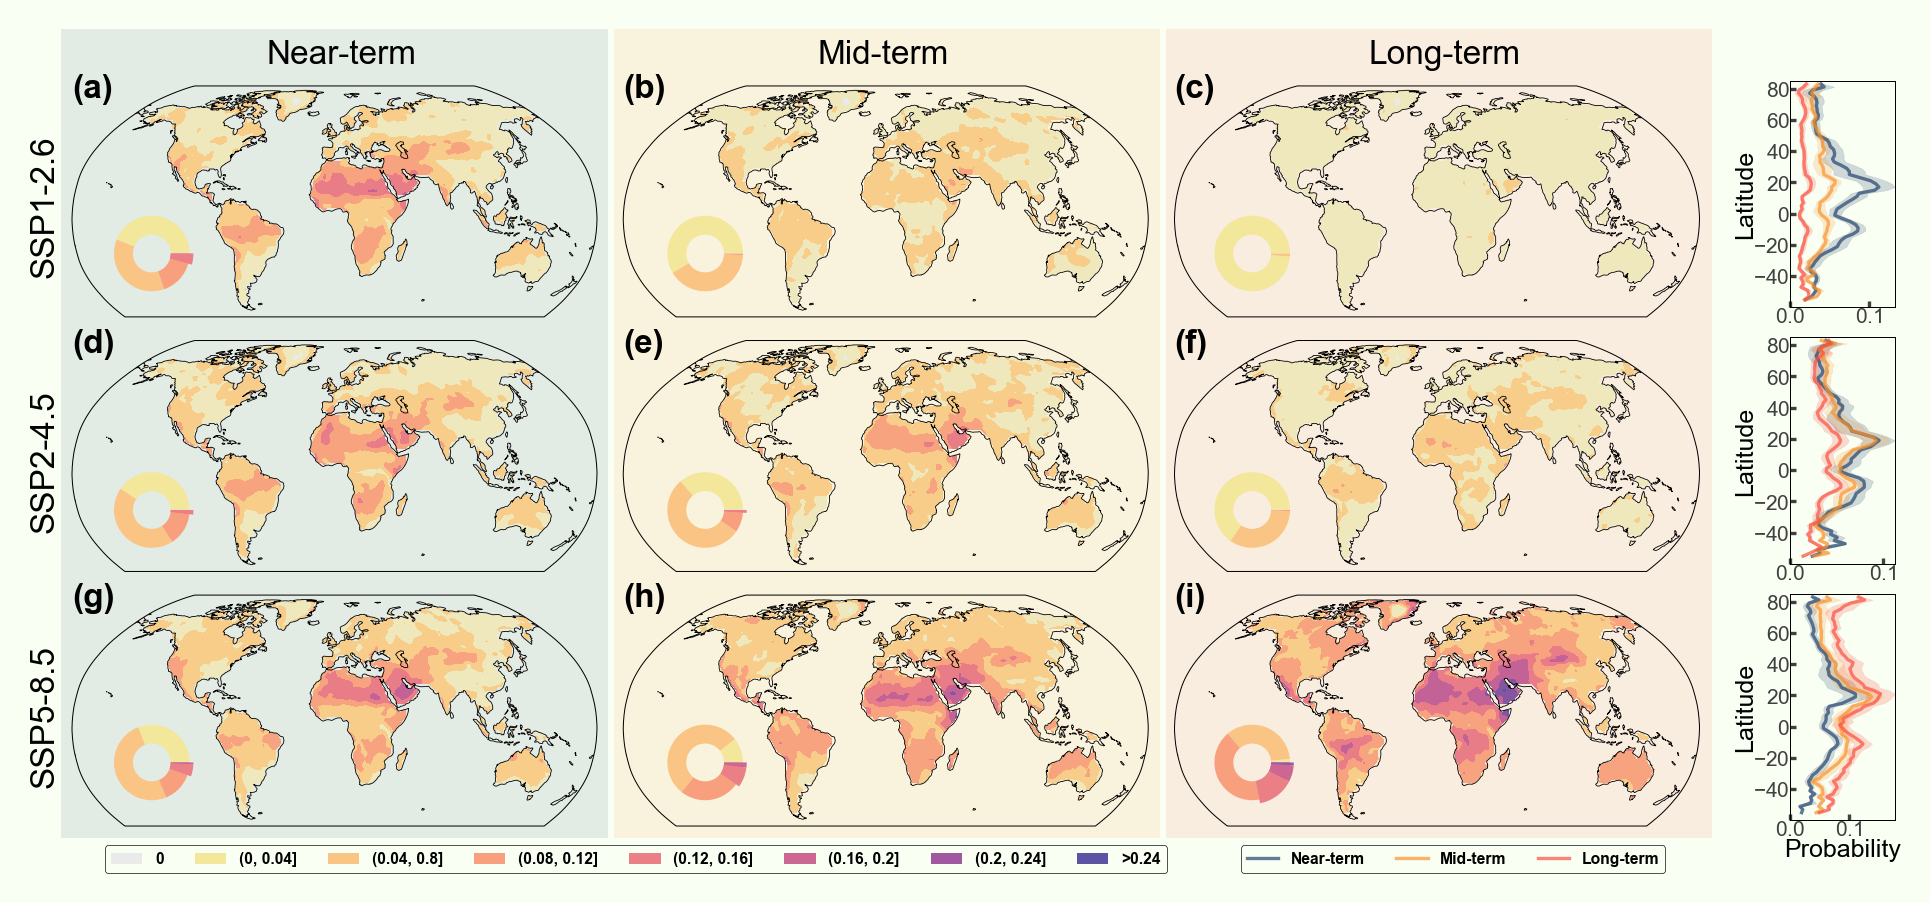

In [81]:
fig = plt.figure(figsize=(7,4.5), dpi=300)

mpl.rcParams['hatch.linewidth'] = 0.2
plt.rcParams["font.sans-serif"] = "Arial"
# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams.update({"font.size":8})
projection = ccrs.Robinson()

ax1 = fig.add_subplot(3, 3, 1,
                      projection=projection)

lon, lat, array1 = get_geotiff_data(r"F:\CMIP6_eco\CDHW\CDHW_record_shattering_probabilities_multimean_resampled\ssp126\CDHW_RSP_ssp126_2020_2039_2sigma.tif")

draw(ax1, '', lon, lat, array1, vmin=0, vmax=0.24, levels=[0, 0.0001, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24, 1], cmap=newcmap, number="(a)")
ax111 = plt.axes([0.128, 0.61, 0.07, 0.07])
draw_proportion_chart(ax111, array1, [0, 0.0001, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24, 1], [0, 0.0001, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24, 1], newcmap, colors=clist4)
# gdf = gpd.read_file(r"E:\l3\创纪录极端复合干旱热浪事件影响生态系统生产力\Climate Reference regions\IPCC-WGI-reference-regions-v4_shapefile\IPCC-WGI-reference-regions-v4_land.shp")
# draw_vectors(ax1, gdf, projection, "Acronym")



ax2 = fig.add_subplot(3, 3, 2,
                      projection=projection)

lon, lat, array2 = get_geotiff_data(r"F:\CMIP6_eco\CDHW\CDHW_record_shattering_probabilities_multimean_resampled\ssp126\CDHW_RSP_ssp126_2040_2059_2sigma.tif")
# p_value = rioxarray.open_rasterio(r"G:\SPEI_calculation\corr\p_value_era5.tif")
# array2[array2!=0] = array2[array2!=0] + 0.0001
draw(ax2, '', lon, lat, array2, vmin=0, vmax=0.24, levels=[0, 0.0001, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24, 1], cmap=newcmap, number="(b)")


ax122 = plt.axes([0.3915, 0.61, 0.07, 0.07])
draw_proportion_chart(ax122, array2, [0, 0.0001, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24, 1], [0, 0.0001, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24, 1], newcmap, colors=clist4)
# gdf = gpd.read_file(r"E:\l3\创纪录极端复合干旱热浪事件影响生态系统生产力\Climate Reference regions\IPCC-WGI-reference-regions-v4_shapefile\IPCC-WGI-reference-regions-v4_land.shp")
# draw_vectors(ax1, gdf, projection, "Acronym")

ax3 = fig.add_subplot(3, 3, 3,
                      projection=projection)

lon, lat, array3 = get_geotiff_data(r"F:\CMIP6_eco\CDHW\CDHW_record_shattering_probabilities_multimean_resampled\ssp126\CDHW_RSP_ssp126_2080_2099_2sigma.tif")
# p_value = rioxarray.open_rasterio(r"G:\SPEI_calculation\corr\p_value_era5.tif")
draw(ax3, '', lon, lat, array3, vmin=0, vmax=0.24, levels=[0, 0.0001, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24, 1], cmap=newcmap, number="(c)")

ax123 = plt.axes([0.652, 0.61, 0.07, 0.07])
draw_proportion_chart(ax123, array3, [0, 0.0001, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24, 1], [0, 0.0001, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24, 1], newcmap, colors=clist4)

ax11 = plt.axes([0.943, 0.605, 0.05, 0.168])
draw_lat_plot(ax11, lat[::-1], array1, array2, array3)

ax4 = fig.add_subplot(3, 3, 4,
                      projection=projection)

lon, lat, array4 = get_geotiff_data(r"F:\CMIP6_eco\CDHW\CDHW_record_shattering_probabilities_multimean_resampled\ssp245\CDHW_RSP_ssp245_2020_2039_2sigma.tif")
# p_value = rioxarray.open_rasterio(r"G:\SPEI_calculation\corr\p_value_era5.tif")
draw(ax4, '', lon, lat, array4, vmin=0, vmax=0.24, levels=[0, 0.0001, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24, 1], cmap=newcmap, number="(d)")

ax124 = plt.axes([0.128, 0.420, 0.07, 0.07])
draw_proportion_chart(ax124, array4, [0, 0.0001, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24, 1], [0, 0.0001, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24, 1], newcmap, colors=clist4)

ax5 = fig.add_subplot(3, 3, 5,
                      projection=projection)

lon, lat, array5 = get_geotiff_data(r"F:\CMIP6_eco\CDHW\CDHW_record_shattering_probabilities_multimean_resampled\ssp245\CDHW_RSP_ssp245_2040_2059_2sigma.tif")
# p_value = rioxarray.open_rasterio(r"G:\SPEI_calculation\corr\p_value_era5.tif")
draw(ax5, '', lon, lat, array5, vmin=0, vmax=0.24, levels=[0, 0.0001, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24, 1], cmap=newcmap, number="(e)")

ax125 = plt.axes([0.3915, 0.420, 0.07, 0.07])
draw_proportion_chart(ax125, array5, [0, 0.0001, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24, 1], [0, 0.0001, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24, 1], newcmap, colors=clist4)

ax6 = fig.add_subplot(3, 3, 6,
                      projection=projection)

lon, lat, array6 = get_geotiff_data(r"F:\CMIP6_eco\CDHW\CDHW_record_shattering_probabilities_multimean_resampled\ssp245\CDHW_RSP_ssp245_2080_2099_2sigma.tif")
# p_value = rioxarray.open_rasterio(r"G:\SPEI_calculation\corr\p_value_era5.tif")
draw(ax6, '', lon, lat, array6, vmin=0, vmax=0.24, levels=[0, 0.0001, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24, 1], cmap=newcmap, number="(f)")



ax126 = plt.axes([0.652, 0.420, 0.07, 0.07])
draw_proportion_chart(ax126, array6, [0, 0.0001, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24, 1], [0, 0.0001, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24, 1], newcmap, colors=clist4)

ax22 = plt.axes([0.943, 0.415, 0.05, 0.168])
draw_lat_plot(ax22, lat[::-1], array4, array5, array6)

ax7 = fig.add_subplot(3, 3, 7,
                      projection=projection)

lon, lat, array7 = get_geotiff_data(r"F:\CMIP6_eco\CDHW\CDHW_record_shattering_probabilities_multimean_resampled\ssp585\CDHW_RSP_ssp585_2020_2039_2sigma.tif")
# p_value = rioxarray.open_rasterio(r"G:\SPEI_calculation\corr\p_value_era5.tif")
draw(ax7, '', lon, lat, array7, vmin=0, vmax=0.24, levels=[0, 0.0001, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24, 1], cmap=newcmap, number="(g)")

ax127 = plt.axes([0.128, 0.233, 0.07, 0.07])
draw_proportion_chart(ax127, array7, [0, 0.0001, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24, 1], [0, 0.0001, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24, 1], newcmap, colors=clist4)

ax8 = fig.add_subplot(3, 3, 8,
                      projection=projection)

lon, lat, array8 = get_geotiff_data(r"F:\CMIP6_eco\CDHW\CDHW_record_shattering_probabilities_multimean_resampled\ssp585\CDHW_RSP_ssp585_2040_2059_2sigma.tif")
# p_value = rioxarray.open_rasterio(r"G:\SPEI_calculation\corr\p_value_era5.tif")
draw(ax8, '', lon, lat, array8, vmin=0, vmax=0.24, levels=[0, 0.0001, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24, 1], cmap=newcmap, number="(h)")

ax128 = plt.axes([0.3915, 0.233, 0.07, 0.07])
draw_proportion_chart(ax128, array8, [0, 0.0001, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24, 1], [0, 0.0001, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24, 1], newcmap, colors=clist4)
fig.subplots_adjust(hspace=-0.3, wspace=0.05)

ax9 = fig.add_subplot(3, 3, 9,
                      projection=projection)

lon, lat, array9 = get_geotiff_data(r"F:\CMIP6_eco\CDHW\CDHW_record_shattering_probabilities_multimean_resampled\ssp585\CDHW_RSP_ssp585_2080_2099_2sigma.tif")
# p_value = rioxarray.open_rasterio(r"G:\SPEI_calculation\corr\p_value_era5.tif")
draw(ax9, '', lon, lat, array9, vmin=0, vmax=0.24, levels=[0, 0.0001, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24, 1], cmap=newcmap, number="(i)")

ax129 = plt.axes([0.652, 0.233, 0.07, 0.07])
draw_proportion_chart(ax129, array9, [0, 0.0001, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24, 1], [0, 0.0001, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24, 1], newcmap, colors=clist4)
ax33 = plt.axes([0.943, 0.225, 0.05, 0.168])
draw_lat_plot(ax33, lat[::-1], array7, array8, array9)


fig.subplots_adjust(hspace=-0.52, wspace=0.05)
fig.patch.set_facecolor('#F9FFF3')

ax11.set_facecolor('#F9FFF3')
ax22.set_facecolor('#F9FFF3')
ax33.set_facecolor('#F9FFF3')

#legend
legend_elements = [Patch(facecolor=clist4[0], edgecolor='None',
                         label='0'),
                   Patch(facecolor=clist4[1], edgecolor='None',
                         label='(0, 0.04]'),
                   Patch(facecolor=clist4[2], edgecolor='None',
                         label='(0.04, 0.8]'),
                   Patch(facecolor=clist4[3], edgecolor='None',
                         label='(0.08, 0.12]'),
                   Patch(facecolor=clist4[4], edgecolor='None',
                         label='(0.12, 0.16]'),
                  Patch(facecolor=clist4[5], edgecolor='None',
                         label='(0.16, 0.2]'),
                  Patch(facecolor=clist4[6], edgecolor='None',
                         label='(0.2, 0.24]'),
                  Patch(facecolor=clist4[7], edgecolor='None',
                         label='>0.24')]
leg = ax7.legend(prop={"size": 3.75, "weight": "bold"}, fontsize=8, handles=legend_elements, bbox_to_anchor=(2.1, -0.05), edgecolor='k', ncol=8, facecolor="#F9FFF3")
ax33.set_xlabel("Probability", fontsize=6, labelpad=-0.3)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(0.2)

custom_lines = [Line2D([0], [0], color="#23436C", lw=0.8, alpha=0.7, label="Near-term"),
                Line2D([0], [0], color="#F9922C", lw=0.8, alpha=0.7, label="Mid-term"),
                Line2D([0], [0], color="#FA4F3E", lw=0.8, alpha=0.7, label="Long-term")]
leg = ax8.legend(prop={"size": 3.75, "weight": "bold"}, fontsize=8, handles=custom_lines, bbox_to_anchor=(2, -0.05), edgecolor='k', ncol=3, facecolor="#F9FFF3")
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(0.2)

# adding some elements about scenarios and periods
ax1.text(
        0.37, 1.1, "Near-term",
        fontsize=8,
        transform = ax1.transAxes
    )
ax2.text(
        0.37, 1.1, "Mid-term",
        fontsize=8,
        transform = ax2.transAxes
    )
ax3.text(
        0.37, 1.1, "Long-term",
        fontsize=8,
        transform = ax3.transAxes
    )
ax1.text(
        -0.08, 0.2, "SSP1-2.6",
        fontsize=8,
        rotation=90,
        transform = ax1.transAxes
    )
ax4.text(
        -0.08, 0.2, "SSP2-4.5",
        fontsize=8,
        rotation=90,
        transform = ax4.transAxes
    )
ax7.text(
        -0.08, 0.2, "SSP5-8.5",
        fontsize=8,
        rotation=90,
        transform = ax7.transAxes
    )
rect = patches.Rectangle((-0.02, -0.05), 1.04, 3.5, fill="#23436C", color="#23436C", alpha=0.1, linewidth=0, zorder=-1, transform=ax7.transAxes)
fig.add_artist(rect)
rect = patches.Rectangle((1.032, -0.05), 1.04, 3.5, fill="#F9922C", color="#F9922C", alpha=0.1, linewidth=0, zorder=-1, transform=ax7.transAxes)
fig.add_artist(rect)
rect = patches.Rectangle((2.083, -0.05), 1.04, 3.5, fill="#FA4F3E", color="#FA4F3E", alpha=0.1, linewidth=0, zorder=-1, transform=ax7.transAxes)
fig.add_artist(rect)

ax1.set_facecolor('#E3EBE5')
ax2.set_facecolor('#F9F3DE')
ax3.set_facecolor('#F9EDE0')
ax4.set_facecolor('#E3EBE5')
ax5.set_facecolor('#F9F3DE')
ax6.set_facecolor('#F9EDE0')
ax7.set_facecolor('#E3EBE5')
ax8.set_facecolor('#F9F3DE')
ax9.set_facecolor('#F9EDE0')
plt.savefig(r"E:\l3\创纪录极端复合干旱热浪事件影响生态系统生产力\figs\CMIP6_rsp_future_periods_2sigma.jpg", dpi=300, bbox_inches="tight")

In [82]:
# get the global trend and 95ci in multimodels
models = ["ACCESS-ESM1-5", "CanESM5", "CMCC-ESM2", "EC-Earth3-Veg",
              "EC-Earth3-Veg-LR", "IPSL-CM6A-LR", "MPI-ESM1-2-LR", "NorESM2-LM", "NorESM2-MM"]
years = range(2015, 2100)

ssp_126_df = pd.DataFrame(columns=models)
ssp_245_df = pd.DataFrame(columns=models)
ssp_585_df = pd.DataFrame(columns=models)
for model in models:
    
    ssp126 = gdal.Open(f"F:/CMIP6_eco/CDHW/CDHW_record_shattering_probabilities_25mov_wind/{model}/ssp126/CDHW_RSPMW25_{model}_ssp126_2015_2099_2sigma.tif").ReadAsArray()
    ssp245 = gdal.Open(f"F:/CMIP6_eco/CDHW/CDHW_record_shattering_probabilities_25mov_wind/{model}/ssp245/CDHW_RSPMW25_{model}_ssp245_2015_2099_2sigma.tif").ReadAsArray()
    ssp585 = gdal.Open(f"F:/CMIP6_eco/CDHW/CDHW_record_shattering_probabilities_25mov_wind/{model}/ssp585/CDHW_RSPMW25_{model}_ssp585_2015_2099_2sigma.tif").ReadAsArray()
    ssp126 = np.ma.masked_array(ssp126,mask=(np.isnan(ssp126)))
    ssp245 = np.ma.masked_array(ssp245,mask=(np.isnan(ssp245)))
    ssp585 = np.ma.masked_array(ssp585,mask=(np.isnan(ssp585)))

    for y in years:
        ssp_126_df.loc[y-2015, model] = ssp126[y-2015].mean()
        ssp_245_df.loc[y-2015, model] = ssp245[y-2015].mean()
        ssp_585_df.loc[y-2015, model] = ssp585[y-2015].mean()


In [83]:
#calculate mean/95ci
import numpy as np
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [84]:
ssp_126_df

,ACCESS-ESM1-5,CanESM5,CMCC-ESM2,EC-Earth3-Veg,EC-Earth3-Veg-LR,IPSL-CM6A-LR,MPI-ESM1-2-LR,NorESM2-LM,NorESM2-MM
0,0.027734,0.028758,0.021948,0.022118,0.021424,0.018334,0.016693,0.025838,0.022844
1,0.030793,0.02954,0.021541,0.02322,0.023032,0.019284,0.017705,0.02689,0.02402
2,0.032805,0.034853,0.023459,0.024231,0.024923,0.022385,0.019127,0.028704,0.024839
3,0.033788,0.037162,0.02467,0.026241,0.02757,0.025181,0.019275,0.031077,0.02595
4,0.034606,0.038882,0.02575,0.02823,0.027202,0.02632,0.01953,0.034119,0.0271
...,...,...,...,...,...,...,...,...,...
80,0.011789,0.047959,0.018569,0.009476,0.008595,0.007367,0.005185,0.00868,0.007121
81,0.010789,0.047709,0.019141,0.010894,0.008786,0.007484,0.005272,0.008412,0.006566
82,0.010506,0.047856,0.018686,0.011226,0.008241,0.00717,0.00505,0.008047,0.006594
83,0.009948,0.045441,0.01801,0.011242,0.007489,0.006735,0.004988,0.007864,0.00704


In [85]:
for i in range(len(ssp_126_df)):
    ssp_126_df.loc[i, "mean"], ssp_126_df.loc[i, "bot"], ssp_126_df.loc[i, "top"] = mean_confidence_interval(ssp_126_df.iloc[i, :9], confidence=0.95)
    ssp_245_df.loc[i, "mean"], ssp_245_df.loc[i, "bot"], ssp_245_df.loc[i, "top"] = mean_confidence_interval(ssp_245_df.iloc[i, :9], confidence=0.95)
    ssp_585_df.loc[i, "mean"], ssp_585_df.loc[i, "bot"], ssp_585_df.loc[i, "top"] = mean_confidence_interval(ssp_585_df.iloc[i, :9], confidence=0.95)

In [86]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import colorConverter as cc
import numpy as np
import pandas as pd
# from scipy.interpolate import make_interp_spline
from matplotlib import ticker
import seaborn as sns
from osgeo import gdal
import scipy.stats
from datetime import datetime

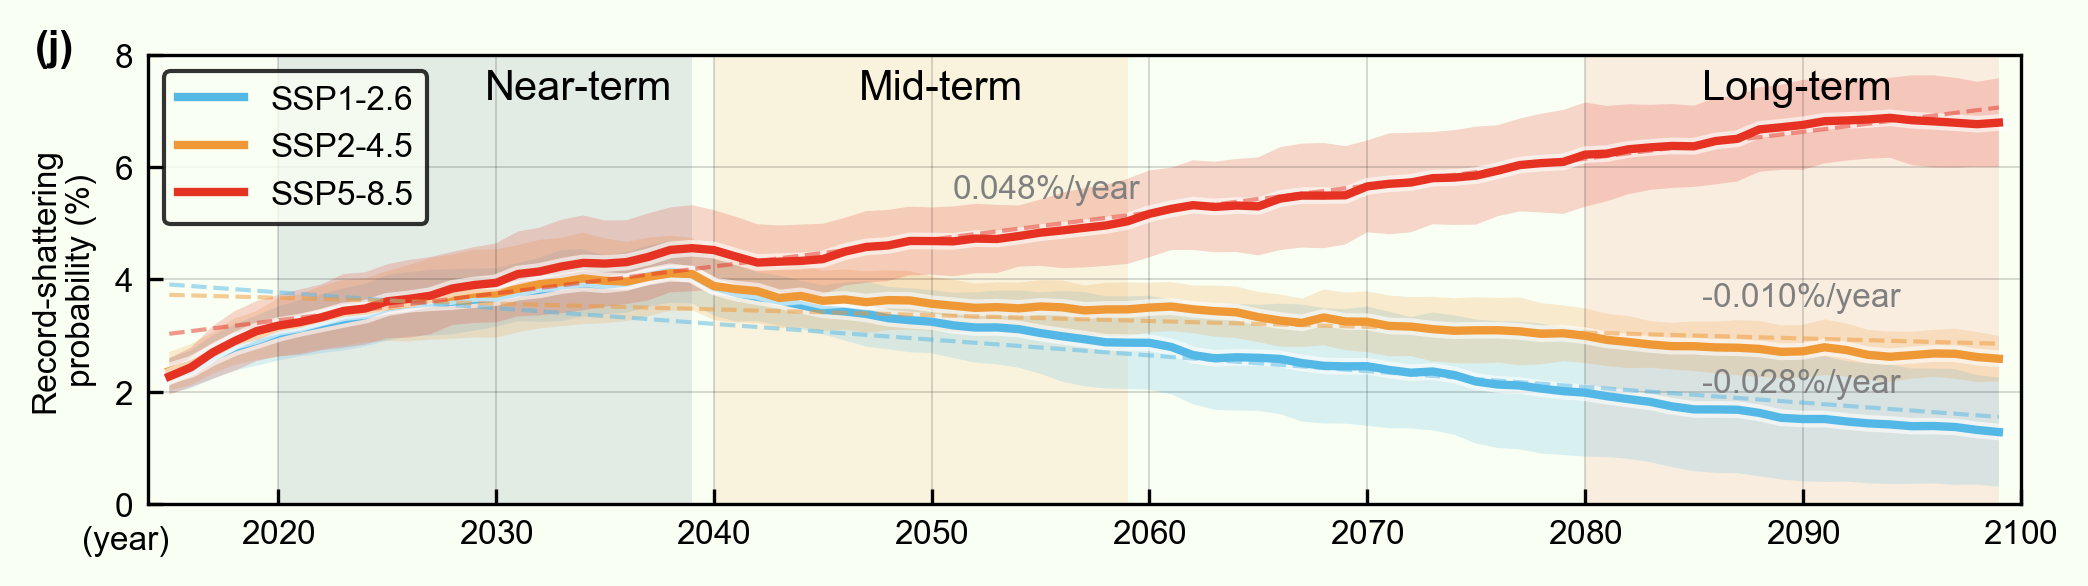

In [87]:
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["axes.formatter.use_mathtext"]=True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
fig = plt.figure(figsize=(7,2), dpi=300)
ax = plt.subplot(1, 1, 1)
    
#ssp126
ax.fill_between(years, ssp_126_df["bot"]*100, ssp_126_df["top"]*100, alpha=0.2, color='#54B8E7', edgecolor=None)
ax.plot(years, ssp_126_df["mean"]*100, color='white', linewidth=4, alpha=0.6)
ax.plot(years, ssp_126_df["mean"]*100, color='#54B8E7',linewidth=2,label='SSP1-2.6')


#ssp245
ax.fill_between(years, ssp_245_df["bot"]*100, ssp_245_df["top"]*100, alpha=0.2, color='#EF9836', edgecolor=None)
ax.plot(years, ssp_245_df["mean"]*100, color='white', linewidth=4, alpha=0.6)
ax.plot(years, ssp_245_df["mean"]*100, color='#EF9836',linewidth=2,label='SSP2-4.5') 
#ssp585
ax.fill_between(years, ssp_585_df["bot"]*100, ssp_585_df["top"]*100, alpha=0.2, color='#E53223', edgecolor=None)
ax.plot(years, ssp_585_df["mean"]*100, color='white', linewidth=4, alpha=0.6)
ax.plot(years,ssp_585_df["mean"]*100, color='#E53223',linewidth=2,label='SSP5-8.5') 
# plt.xlim(datetime(1952, 1, 15), datetime(2022, 12, 31))
#plt.ylim(0,plt.ylim()[1])
# plt.xlim(2020,2090)
plt.tick_params(labelsize=8)
# group_labels = ["2020s", "2030s", "2040s", "2050s", "2060s", "2070s", "2080s", "2090s"]
# ax.set_xticks(time2, group_labels, rotation=30)
# ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0),useLocale=False)  
#plt.ylabel('Exposed length (km)',{'family':'Cambria','weight':'bold','size' : 20})#(J/${m^2}$)
plt.legend(fontsize=8, loc="best", edgecolor='k', facecolor='#F9FFF3')

plt.ylabel('Record-shattering\nprobability (%)',{'family':'Arial','size' : 8})#(J/${m^2}$)

plt.grid( color = 'k',linestyle='-',linewidth = 0.07)
ax.text(
   -0.06, 0.99, "(j)",
    fontsize=10,
    fontweight="bold",
    transform = ax.transAxes
)
#ax.text(2080,ax.get_ylim()[1]*0.8/(ax.get_ylim()[1]-ax.get_ylim()[0]),label[i],size=15)  
# sns.despine()
fig.patch.set_facecolor('#F9FFF3')
ax.set_facecolor('#F9FFF3')
ax.set_xlim(2014, 2100)
ax.text(
   -0.035, -0.1, "(year)",
    fontsize=8,
    transform = ax.transAxes
)
ax.set_ylim(0, 8)
rect = patches.Rectangle((2020, 0.0), 19, 10, linewidth=2, edgecolor='none', facecolor='#23436C', alpha=0.1, zorder=-1)
ax.add_patch(rect)
rect = patches.Rectangle((2040, 0.0), 19, 10, linewidth=2, edgecolor='none', facecolor='#F9922C', alpha=0.1, zorder=-1)
ax.add_patch(rect)
rect = patches.Rectangle((2080, 0.0), 19, 10, linewidth=2, edgecolor='none', facecolor='#FA4F3E', alpha=0.1, zorder=-1)
ax.add_patch(rect)
ax.text(
   0.18, 0.9, "Near-term",
    fontsize=10,
    transform = ax.transAxes
)
ax.text(
   0.38, 0.9, "Mid-term",
    fontsize=10,
    transform = ax.transAxes
)
ax.text(
   0.83, 0.9, "Long-term",
    fontsize=10,
    transform = ax.transAxes
)
z = np.polyfit(years, ssp_126_df["mean"]*100, 1)
p = np.poly1d(z)
ax.plot(years, p(years),color='#54B8E7', linewidth=1, linestyle="--", alpha=0.5)
ax.text(
   0.83, 0.25, "{0:.3f}%/year".format(p[1]),
    fontsize=8,
    color="gray",
    transform = ax.transAxes
)

z = np.polyfit(years, ssp_245_df["mean"]*100, 1)
p = np.poly1d(z)
ax.plot(years, p(years),color='#EF9836', linewidth=1, linestyle="--", alpha=0.5)
ax.text(
   0.83, 0.44, "{0:.3f}%/year".format(p[1]),
    fontsize=8,
    color="gray",
    transform = ax.transAxes
)
z = np.polyfit(years, ssp_585_df["mean"]*100, 1)
p = np.poly1d(z)
ax.plot(years, p(years),color='#E53223', linewidth=1, linestyle="--", alpha=0.5)
ax.text(
   0.43, 0.68, "{0:.3f}%/year".format(p[1]),
    fontsize=8,
    color="gray",
    transform = ax.transAxes
)
plt.tight_layout()
plt.savefig(r"E:\l3\创纪录极端复合干旱热浪事件影响生态系统生产力\figs\CMIP6_rsp_future_mw_2sigma.jpg", dpi=300)

In [102]:
# Dumbbell chart
data = pd.read_excel(r"F:\CMIP6_eco\CDHW\anomalies\zonal_stats\record_shattering_prob_diff_period_2sigma.xlsx")

In [103]:
data

,Unnamed: 0,GIC,NWN,NEN,WNA,CNA,ENA,NCA,SCA,CAR,...,TIB,EAS,ARP,SAS,SEA,NAU,CAU,EAU,SAU,NZ
0,historical_1991_2014_2sigma,0.011605,0.036648,0.046250,0.024765,0.024987,0.015519,0.029158,0.020925,0.027244,...,0.011620,0.010243,0.069261,0.039397,0.015272,0.025124,0.020948,0.000452,0.007571,0.004115
1,ssp126_2020_2039_2sigma,0.028346,0.033643,0.041404,0.051169,0.039243,0.032718,0.060519,0.081582,0.123553,...,0.026865,0.028074,0.127695,0.059000,0.056197,0.061758,0.043766,0.028868,0.027014,0.035317
2,ssp126_2040_2059_2sigma,0.024201,0.031916,0.032306,0.045208,0.023548,0.034518,0.049378,0.050578,0.078337,...,0.023918,0.022959,0.071090,0.048351,0.043666,0.039849,0.036658,0.024249,0.022807,0.022954
3,ssp126_2080_2099_2sigma,0.016117,0.013750,0.019169,0.016793,0.011626,0.014263,0.017770,0.018184,0.017805,...,0.016296,0.012736,0.035020,0.019038,0.013820,0.019360,0.013654,0.012663,0.013113,0.011763
4,ssp245_2020_2039_2sigma,0.034600,0.034789,0.044979,0.049131,0.032492,0.039153,0.064612,0.086588,0.132095,...,0.029915,0.027007,0.113737,0.051572,0.051177,0.063718,0.048571,0.035299,0.029349,0.031917
5,ssp245_2040_2059_2sigma,0.028756,0.040069,0.043479,0.050416,0.034720,0.038461,0.062717,0.070127,0.122504,...,0.027216,0.031203,0.115349,0.059841,0.054959,0.058872,0.054663,0.032062,0.033940,0.027362
6,ssp245_2080_2099_2sigma,0.027398,0.023669,0.031886,0.027445,0.024693,0.034097,0.031464,0.049595,0.065236,...,0.021715,0.027003,0.055213,0.035861,0.034301,0.035045,0.030295,0.032744,0.025682,0.028117
7,ssp585_2020_2039_2sigma,0.034052,0.042644,0.048929,0.075166,0.046078,0.044293,0.069544,0.079450,0.135157,...,0.031520,0.032373,0.147182,0.055367,0.051021,0.068276,0.061249,0.045297,0.036546,0.028352
8,ssp585_2040_2059_2sigma,0.045909,0.055727,0.062595,0.067841,0.053174,0.051150,0.093050,0.118227,0.191764,...,0.050951,0.045882,0.159539,0.092909,0.086861,0.098508,0.078262,0.050468,0.044412,0.038089
9,ssp585_2080_2099_2sigma,0.087878,0.073331,0.096805,0.087623,0.072586,0.090054,0.122173,0.111559,0.148537,...,0.065324,0.061495,0.201777,0.097909,0.064386,0.103576,0.096021,0.094185,0.086724,0.045807


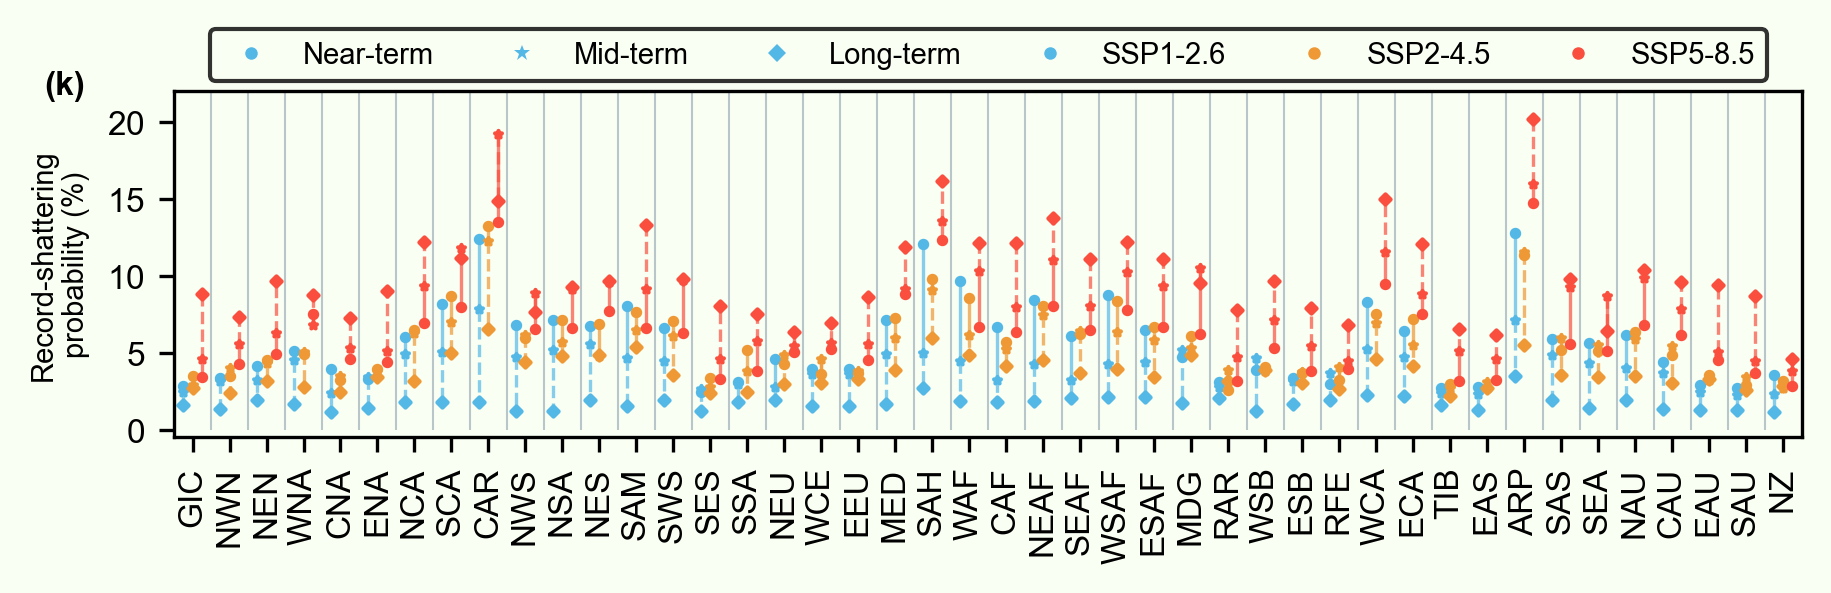

In [90]:
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["axes.formatter.use_mathtext"]=True
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
fig = plt.figure(figsize=(7,1.5), dpi=300)
ax = plt.subplot(1, 1, 1)
fig.patch.set_facecolor('#F9FFF3')
ax.set_facecolor('#F9FFF3')
x_ssp126 = list(range(0, 3*44, 3))
x_ssp245 = list(range(1, 3*44, 3))
x_ssp585 = list(range(2, 3*44, 3))
space = 0
for i in range(44):
        
    x_ssp126[i] = x_ssp126[i] + space
    x_ssp245[i] = x_ssp245[i] + space
    x_ssp585[i] = x_ssp585[i] + space
    space += 1

#ssp126
ax.vlines(x=x_ssp126, ymin=data.iloc[1, 1:]*100, ymax=data.iloc[2, 1:]*100, color='#54B8E7', linewidth=0.8, linestyle="-", alpha=0.7)
ax.vlines(x=x_ssp126, ymin=data.iloc[2, 1:]*100, ymax=data.iloc[3, 1:]*100, color='#54B8E7', linewidth=0.8, linestyle="--", alpha=0.7)

#ssp245
ax.vlines(x=x_ssp245, ymin=data.iloc[4, 1:]*100, ymax=data.iloc[5, 1:]*100, color='#EF9836', linewidth=0.8, linestyle="-", alpha=0.7)
ax.vlines(x=x_ssp245, ymin=data.iloc[5, 1:]*100, ymax=data.iloc[6, 1:]*100, color='#EF9836', linewidth=0.8, linestyle="--", alpha=0.7)

#ssp126
ax.vlines(x=x_ssp585, ymin=data.iloc[7, 1:]*100, ymax=data.iloc[8, 1:]*100, color='#FA4F3E', linewidth=0.8, linestyle="-", alpha=0.7)
ax.vlines(x=x_ssp585, ymin=data.iloc[8, 1:]*100, ymax=data.iloc[9, 1:]*100, color='#FA4F3E', linewidth=0.8, linestyle="--", alpha=0.7)

ax.scatter(x_ssp126, data.iloc[1, 1:]*100, s=3, color='#54B8E7', alpha=1, marker="o", label='Near-term')
ax.scatter(x_ssp126, data.iloc[2, 1:]*100, s=3, color='#54B8E7', alpha=1, marker="*", label='Mid-term')
ax.scatter(x_ssp126, data.iloc[3, 1:]*100, s=3, color='#54B8E7', alpha=1, marker="D", label='Long-term')

ax.scatter(x_ssp245, data.iloc[4, 1:]*100, s=3, color='#EF9836', alpha=1, marker="o", label='Near-term')
ax.scatter(x_ssp245, data.iloc[5, 1:]*100, s=3, color='#EF9836', alpha=1, marker="*", label='Mid-term')
ax.scatter(x_ssp245, data.iloc[6, 1:]*100, s=3, color='#EF9836', alpha=1, marker="D", label='Long-term')

ax.scatter(x_ssp585, data.iloc[7, 1:]*100, s=3, color='#FA4F3E', alpha=1, marker="o", label='Near-term')
ax.scatter(x_ssp585, data.iloc[8, 1:]*100, s=3, color='#FA4F3E', alpha=1, marker="*", label='Mid-term')
ax.scatter(x_ssp585, data.iloc[9, 1:]*100, s=3, color='#FA4F3E', alpha=1, marker="D", label='Long-term')

ax.set_ylim(-0.5, 22)
ax.vlines(range(3, 4*43, 4), 0, 30, linestyle="-", linewidth=0.5, color="#23436C", alpha=0.3)
ax.set_xlim(-1, 175)
plt.ylabel('Record-shattering\nprobability (%)',{'family':'Arial','size' : 7})#(J/${m^2}$)
ax.text(
   -0.08, 0.99, "(k)",
    fontsize=8,
    fontweight="bold",
    transform = ax.transAxes
)
# xlabels
subcontinels = ['GIC', 'NWN', 'NEN', 'WNA', 'CNA', 'ENA', 'NCA', 'SCA', 'CAR', 'NWS',
       'NSA', 'NES', 'SAM', 'SWS', 'SES', 'SSA', 'NEU', 'WCE', 'EEU', 'MED',
       'SAH', 'WAF', 'CAF', 'NEAF', 'SEAF', 'WSAF', 'ESAF', 'MDG', 'RAR',
       'WSB', 'ESB', 'RFE', 'WCA', 'ECA', 'TIB', 'EAS', 'ARP', 'SAS', 'SEA',
       'NAU', 'CAU', 'EAU', 'SAU', 'NZ']
ax.set_xticks(x_ssp245, subcontinels, rotation=90)

legend_elements = [Line2D([0], [0], marker='o', color='none', label='Near-term',
                          markerfacecolor='#54B8E7', markersize=3, markeredgecolor="none"),
                  Line2D([0], [0], marker='*', color='none', label='Mid-term',
                          markerfacecolor='#54B8E7', markersize=4, markeredgecolor="none"),
                  Line2D([0], [0], marker='D', color='none', label='Long-term',
                          markerfacecolor='#54B8E7', markersize=3, markeredgecolor="none"),
                  Line2D([0], [0], marker='o', color='none', label='SSP1-2.6',
                          markerfacecolor='#54B8E7', markersize=3, markeredgecolor="none"),
                  Line2D([0], [0], marker='o', color='none', label='SSP2-4.5',
                          markerfacecolor='#EF9836', markersize=3, markeredgecolor="none"),
                  Line2D([0], [0], marker='o', color='none', label='SSP5-8.5',
                          markerfacecolor='#FA4F3E', markersize=3, markeredgecolor="none")]
leg = ax.legend( fontsize=7, handles=legend_elements, loc=(0.022, 1.03), edgecolor='k', ncol=6, facecolor="#F9FFF3")
# leg.get_frame().set_edgecolor('black')
# leg.get_frame().set_linewidth(0.2)
plt.savefig(r"E:\l3\创纪录极端复合干旱热浪事件影响生态系统生产力\figs\CMIP6_rsp_future_mw_2sigma_dumb.jpg", dpi=300, bbox_inches="tight")

In [104]:
# heatmap for the rate of record-shattering probabilities change
rsp_data = pd.read_excel(r"F:\CMIP6_eco\CDHW\anomalies\zonal_stats\record_shattering_prob_mw_ts_2sigma.xlsx")

In [105]:
import statsmodels.api as sm
def lm_trend(x):
        
    years = np.arange(1,86)
    years = sm.add_constant(years)
    model = sm.OLS(x,years)
    result = model.fit()
    #print(result.summary())
    slope = result.params[1]
    p = result.pvalues[1]
    return(slope , p )

In [106]:
rsp_data

,Unnamed: 0,GIC,NWN,NEN,WNA,CNA,ENA,NCA,SCA,CAR,...,TIB,EAS,ARP,SAS,SEA,NAU,CAU,EAU,SAU,NZ
0,ssp126_2sigma_2015,0.023128,0.025574,0.034358,0.042180,0.022322,0.020837,0.036904,0.031158,0.066416,...,0.019736,0.013594,0.106266,0.027908,0.023538,0.025764,0.031147,0.023482,0.013277,0.014993
1,ssp126_2sigma_2016,0.024718,0.027124,0.037208,0.044442,0.023269,0.021427,0.037649,0.028673,0.076077,...,0.022760,0.014780,0.114490,0.027442,0.023447,0.026124,0.029583,0.023482,0.013446,0.017132
2,ssp126_2sigma_2017,0.027532,0.028517,0.040436,0.046567,0.024699,0.024254,0.041958,0.032707,0.086949,...,0.024409,0.015473,0.124061,0.030195,0.024807,0.031083,0.030327,0.025524,0.013829,0.017938
3,ssp126_2sigma_2018,0.029155,0.030053,0.042109,0.047424,0.025760,0.025352,0.042717,0.035450,0.096734,...,0.024799,0.017044,0.133351,0.032042,0.026600,0.034599,0.033027,0.032102,0.015105,0.018034
4,ssp126_2sigma_2019,0.030377,0.032394,0.044437,0.052029,0.028315,0.024833,0.045719,0.037237,0.104889,...,0.025443,0.017018,0.139672,0.033557,0.027498,0.037807,0.037660,0.032645,0.016666,0.018282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,ssp585_2sigma_2095,0.086818,0.071221,0.090861,0.093053,0.083623,0.093531,0.120895,0.110099,0.155998,...,0.062858,0.056350,0.196966,0.093454,0.066335,0.103556,0.089831,0.082108,0.080363,0.050001
251,ssp585_2sigma_2096,0.086881,0.069277,0.090438,0.091185,0.080027,0.088389,0.119702,0.110288,0.154803,...,0.064208,0.057078,0.194180,0.093143,0.063266,0.101017,0.093943,0.088291,0.083890,0.050180
252,ssp585_2sigma_2097,0.089969,0.068317,0.089662,0.088760,0.076563,0.086964,0.122285,0.114531,0.152507,...,0.064306,0.056793,0.194301,0.093804,0.061940,0.104368,0.094986,0.089042,0.085423,0.048519
253,ssp585_2sigma_2098,0.088270,0.068335,0.091049,0.095894,0.075215,0.089326,0.120879,0.116278,0.153248,...,0.066015,0.058342,0.192415,0.092533,0.061290,0.101581,0.092984,0.090423,0.084671,0.048210


In [107]:
p_df = pd.DataFrame(columns=rsp_data.columns[1:])
slope_df = pd.DataFrame(columns=rsp_data.columns[1:])
for count in range(3):
    for c in rsp_data.columns[1:]:
        _x = rsp_data.loc[0+count*85: 84+count*85, c]
        _slope, _p = lm_trend(_x)
        slope_df.loc[count, c] = _slope
        p_df.loc[count, c] = _p 

In [108]:
slope_df = slope_df.astype("float32")

In [109]:
slope_df = slope_df * 100

In [111]:
slope_df.loc[2, :]

GIC     0.067694
NWN     0.053308
NEN     0.064373
WNA     0.044926
CNA     0.055919
ENA     0.079346
NCA     0.079056
SCA     0.082612
CAR     0.055117
NWS     0.051058
NSA     0.064730
NES     0.049382
SAM     0.097251
SWS     0.078474
SES     0.082400
SSA     0.074852
NEU     0.047305
WCE     0.050057
EEU     0.056993
MED     0.060616
SAH     0.068224
WAF     0.070580
CAF     0.093986
NEAF    0.085497
SEAF    0.072498
WSAF    0.080457
ESAF    0.078972
MDG     0.075232
RAR     0.065609
WSB     0.081437
ESB     0.078238
RFE     0.042792
WCA     0.077024
ECA     0.081079
TIB     0.053740
EAS     0.052589
ARP     0.042527
SAS     0.079842
SEA     0.049596
NAU     0.081593
CAU     0.071726
EAU     0.049803
SAU     0.085058
NZ      0.048486
Name: 2, dtype: float32

In [97]:
slope_df.describe()

,GIC,NWN,NEN,WNA,CNA,ENA,NCA,SCA,CAR,NWS,...,TIB,EAS,ARP,SAS,SEA,NAU,CAU,EAU,SAU,NZ
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.012906,0.007685,0.007580,-0.015455,0.002133,0.022232,0.001554,0.008030,-0.049295,-0.001985,...,0.015000,0.019189,-0.075389,0.016871,0.008098,0.008105,0.010782,0.003885,0.029172,0.009335
std,0.048220,0.039684,0.050159,0.052372,0.046762,0.050316,0.068588,0.068643,0.099859,0.048468,...,0.033794,0.030120,0.107209,0.055555,0.038789,0.065518,0.055750,0.040903,0.049408,0.034287
min,-0.023084,-0.018830,-0.030654,-0.048561,-0.028881,-0.015556,-0.051314,-0.052499,-0.143873,-0.043965,...,-0.008423,-0.005909,-0.166991,-0.025213,-0.027247,-0.044204,-0.037648,-0.028649,-0.008707,-0.015338
25%,-0.014488,-0.015127,-0.020816,-0.045645,-0.024761,-0.006324,-0.037198,-0.029260,-0.101502,-0.028506,...,-0.004370,0.002489,-0.134347,-0.014614,-0.012651,-0.028638,-0.019689,-0.019074,0.001229,-0.010241
50%,-0.005891,-0.011425,-0.010978,-0.042729,-0.020641,0.002907,-0.023082,-0.006021,-0.059130,-0.013048,...,-0.000317,0.010886,-0.101703,-0.004015,0.001945,-0.013073,-0.001731,-0.009499,0.011164,-0.005144
75%,0.030901,0.020942,0.026698,0.001098,0.017639,0.041126,0.027987,0.038295,-0.002006,0.019005,...,0.026711,0.031737,-0.029588,0.037914,0.025770,0.034260,0.034998,0.020152,0.048111,0.021671
max,0.067694,0.053308,0.064373,0.044926,0.055919,0.079346,0.079056,0.082612,0.055117,0.051058,...,0.053740,0.052589,0.042527,0.079842,0.049596,0.081593,0.071726,0.049803,0.085058,0.048486


In [98]:
np.array(slope_df).max()

0.097250886

In [99]:
p_df>0.05

,GIC,NWN,NEN,WNA,CNA,ENA,NCA,SCA,CAR,NWS,...,TIB,EAS,ARP,SAS,SEA,NAU,CAU,EAU,SAU,NZ
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,True,False,True,False,False,...,True,False,False,True,True,False,True,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


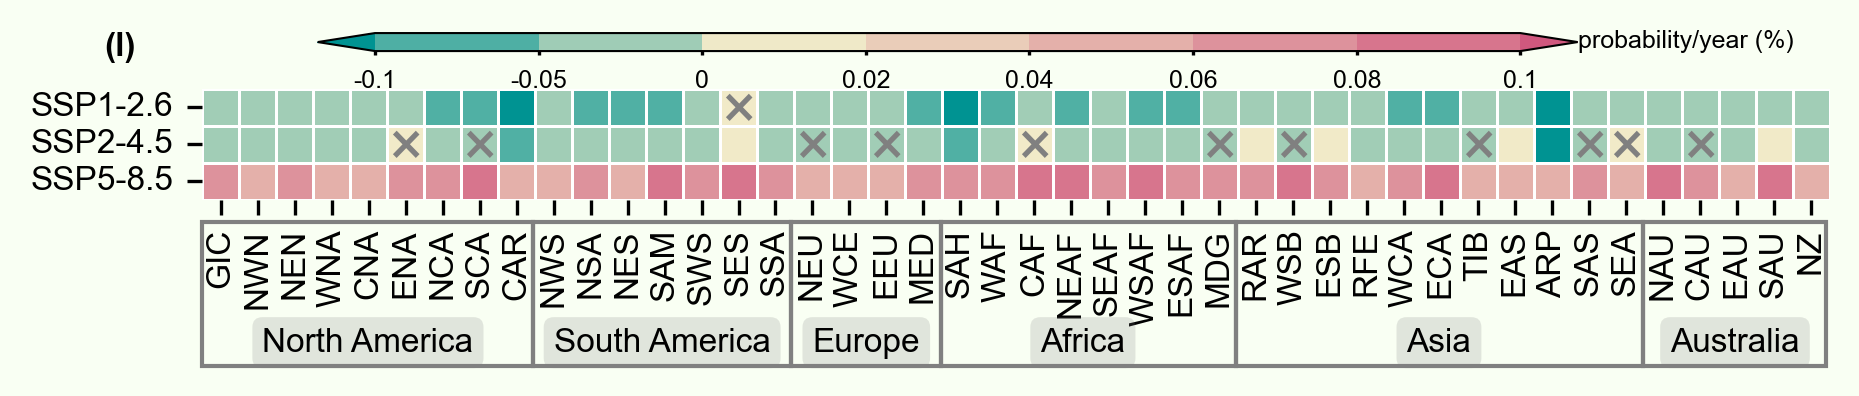

In [100]:
import seaborn as sb
from matplotlib.colors import BoundaryNorm
fig = plt.figure(figsize=(7,2), dpi=300)
mpl.rcParams['hatch.linewidth'] = 0.2
plt.rcParams["font.sans-serif"] = "Arial"
# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams.update({"font.size":8})
# plot heatmap

ax1 = fig.add_subplot(1, 1, 1)
data_fig = slope_df
data_fig.index = ["SSP1-2.6", "SSP2-4.5", "SSP5-8.5"]
p_df.index = ["SSP1-2.6", "SSP2-4.5", "SSP5-8.5"]
trend_color_list = ["#009392", "#50b0a4", "#a1cdb6",'#f1eac8', '#eacdb9', '#e4b0aa', '#dd929c', '#d7758d', '#d0587e']
bounds = [-0.1, -0.05, 0, 0.02, 0.04, 0.06, 0.08, 0.1]
my_norm = BoundaryNorm(bounds, len(trend_color_list), extend="both")

sb.heatmap(data_fig,  cmap=trend_color_list, vmin= -0.1, vmax=0.1, norm=my_norm, square=True,
           linewidth=0.3, cbar=False)
# significance
widthx = 0
widthy = 0.6
parr = np.array(p_df)
for m in ax1.get_xticks():
    for n in ax1.get_yticks():
        pv = (parr[int(n),int(m)])
        if pv >= 0.05:
            ax1.text(m+widthx,n+widthy,'×',ha = 'center',color = 'gray', fontsize=15, fontweight=10)

#cbar
newcmap_cb = LinearSegmentedColormap.from_list('chaos',trend_color_list)
ax999 = plt.axes([0.18, 0.65, 0.6, 0.03])
my_norm = BoundaryNorm(bounds, newcmap_cb.N, extend="both")
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=my_norm, cmap=newcmap_cb), cax=ax999, orientation="horizontal", ticks=[-0.1, -0.05, 0, 0.02, 0.04, 0.06, 0.08, 0.1], extend="both")
cbar.ax.set_xticklabels([-0.1, -0.05, 0, 0.02, 0.04, 0.06, 0.08, 0.1], fontsize=6)
cbar.ax.tick_params(size=1)
cbar.outline.set_linewidth(0.5)
ax999.text(
        1.05, 0.2, "probability/year (%)",
        fontsize=6,
        transform = ax999.transAxes
    )


ax1.text(-0.06, 1.3, "(l)", fontsize=8, fontweight="bold", transform=ax1.transAxes)
# NA
rect = patches.Rectangle((0.0, -1.5), 0.203, 1.3, fill=False, color="gray", linewidth=1, zorder=10, transform=ax1.transAxes)
fig.add_artist(rect)

# SA
rect = patches.Rectangle((0.203, -1.5), 0.159, 1.3, fill=False, color="gray", linewidth=1, zorder=10, transform=ax1.transAxes)
fig.add_artist(rect)

# EU
rect = patches.Rectangle((0.362, -1.5), 0.092, 1.3, fill=False, color="gray", linewidth=1, zorder=10, transform=ax1.transAxes)
fig.add_artist(rect)

# AF
rect = patches.Rectangle((0.454, -1.5), 0.181, 1.3, fill=False, color="gray", linewidth=1, zorder=10, transform=ax1.transAxes)
fig.add_artist(rect)

# AS
rect = patches.Rectangle((0.635, -1.5), 0.25, 1.3, fill=False, color="gray", linewidth=1, zorder=10, transform=ax1.transAxes)
fig.add_artist(rect)

# AU
rect = patches.Rectangle((0.885, -1.5), 0.113, 1.3, fill=False, color="gray", linewidth=1, zorder=10, transform=ax1.transAxes)
fig.add_artist(rect)

props = dict(boxstyle='round', facecolor='gray', alpha=0.2, edgecolor="none")
ax1.text(0.037, -1.15, "North America", transform=ax1.transAxes, fontsize=8, verticalalignment='top', bbox=props)
ax1.text(0.216, -1.15, "South America", transform=ax1.transAxes, fontsize=8, verticalalignment='top', bbox=props)
ax1.text(0.375, -1.15, "Europe", transform=ax1.transAxes, fontsize=8, verticalalignment='top', bbox=props)
ax1.text(0.515, -1.15, "Africa", transform=ax1.transAxes, fontsize=8, verticalalignment='top', bbox=props)
ax1.text(0.74, -1.15, "Asia", transform=ax1.transAxes, fontsize=8, verticalalignment='top', bbox=props)
ax1.text(0.902, -1.15, "Australia", transform=ax1.transAxes, fontsize=8, verticalalignment='top', bbox=props)
fig.patch.set_facecolor('#F9FFF3')
ax.set_facecolor('#F9FFF3')
plt.savefig(r"E:\l3\创纪录极端复合干旱热浪事件影响生态系统生产力\figs\CMIP6_rsp_future_mw_2sigma_heatmap.jpg", bbox_inches="tight", dpi=300)

In [68]:
ax.get_xticks()

array([  1,   5,   9,  13,  17,  21,  25,  29,  33,  37,  41,  45,  49,
        53,  57,  61,  65,  69,  73,  77,  81,  85,  89,  93,  97, 101,
       105, 109, 113, 117, 121, 125, 129, 133, 137, 141, 145, 149, 153,
       157, 161, 165, 169, 173])

In [69]:
print(p_df.columns)

Index(['GIC', 'NWN', 'NEN', 'WNA', 'CNA', 'ENA', 'NCA', 'SCA', 'CAR', 'NWS',
       'NSA', 'NES', 'SAM', 'SWS', 'SES', 'SSA', 'NEU', 'WCE', 'EEU', 'MED',
       'SAH', 'WAF', 'CAF', 'NEAF', 'SEAF', 'WSAF', 'ESAF', 'MDG', 'RAR',
       'WSB', 'ESB', 'RFE', 'WCA', 'ECA', 'TIB', 'EAS', 'ARP', 'SAS', 'SEA',
       'NAU', 'CAU', 'EAU', 'SAU', 'NZ'],
      dtype='object')
